# **GROUP 5: AOL Machine Learning - Fake News Detection**

1. Ebenhaezer George Renaldi Muljadi - 2702230461
2. Farrel Christian Ardan - 2702308685
3. Andrew Yappie Dwiputra - 2702323603

In [22]:
# 1. Mount Drive & Load Dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
true_path = '/content/drive/MyDrive/DatasetML/True.csv'
fake_path = '/content/drive/MyDrive/DatasetML/Fake.csv'

trueDF = pd.read_csv(true_path)
fakeDF = pd.read_csv(fake_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# 2. Cek Null & Duplicates
trueDF.drop_duplicates(inplace=True)
fakeDF.drop_duplicates(inplace=True)

In [24]:
# 3. Labeling & Gabung Dataset
trueDF['label'] = 1
fakeDF['label'] = 0
df = pd.concat([trueDF, fakeDF], ignore_index=True)

In [25]:
# 4. Drop kolom tidak penting & Gabungkan teks
df.drop(['subject', 'date'], axis=1, inplace=True)
df['content'] = df['title'] + ' ' + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

In [26]:
# 5. Preprocessing (Stemming + Stopwords)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    return ' '.join([stemmer.stem(word) for word in text if word not in stop_words])

df['content'] = df['content'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# 6. Feature Extraction & Split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df['content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [28]:
# 7. Train Model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

In [40]:
# 8. Evaluation on Test Set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_vec)
y_probs = model.predict_proba(X_test_vec)[:, 1]

print("Evaluation on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_probs):.4f}")

Evaluation on Test Set
Accuracy: 0.9871
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4738
           1       0.99      0.99      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

Confusion Matrix:
[[4680   58]
 [  57 4143]]
ROC AUC Score: 0.9985


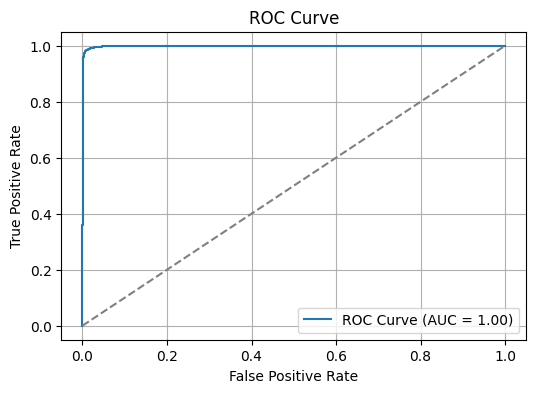

In [34]:
# 9. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probs)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# 10. Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(model, X_train_vec, y_train, cv=cv, scoring=scoring)

print("5-Fold Cross-Validation Results")
for metric in scoring:
    mean = cv_results[f'test_{metric}'].mean()
    std = cv_results[f'test_{metric}'].std()
    print(f"{metric.capitalize():<10}: {mean:.4f} ± {std:.4f}")

5-Fold Cross-Validation Results
Accuracy  : 0.9857 ± 0.0010
Precision : 0.9825 ± 0.0024
Recall    : 0.9875 ± 0.0008
F1        : 0.9850 ± 0.0011
Roc_auc   : 0.9985 ± 0.0003


In [39]:
# 11. Prediksi Manual
def predict_news_authenticity(news_text):
    processed = preprocess(news_text)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)
    print(f"Prediction: {'True' if prediction[0] == 1 else 'Fake'}")

newsEx = [
    "United Nations Secretary-General António Guterres urged world leaders at the G20 Summit to take urgent climate action. He emphasized the importance of reducing carbon emissions and transitioning to renewable energy sources. The summit, held in New Delhi, focused on sustainability and economic recovery post-pandemic.",
    "A viral claim states that NASA has confirmed the Earth will undergo 6 days of complete darkness due to a solar storm. According to the report, this phenomenon is expected to start on November 15 and last until November 20. However, NASA has not released any official statement regarding such an event."
]

for news in newsEx:
    predict_news_authenticity(news)

Prediction: True
Prediction: Fake
